In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display

plt.style.use('Joey')

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps

import mossbauer
from mossbauer.utils import *

from scipy.integrate import simpson, quad, quad_vec
from scipy.special import jv
from scipy.interpolate import interp1d

from os.path import join

from tqdm import tqdm

In [3]:
def change_axis_color(ax, color, x_or_y='y'):
    getattr(ax, x_or_y + 'axis').label.set_color(color)
    ax.tick_params(axis=x_or_y, colors=color)
    return

In [4]:
natural_linewidth = 4.55e-9  # eV
source_activity = 3.7e10 * 0.001  # 1 mCi -> Hz
mossbauer_relative_intensity = 0.0916

### source parameters
source_parameters = dict(
    Eres=0.0,
    linewidth=E_to_vel(natural_linewidth),
    total_activity=mossbauer_relative_intensity * source_activity
)

### absorber parameters
recoilless_fraction_A = 1.
t_mgcm2 = 0.13  # potassium ferrocyanide from ritverc
absorption_coefficient = 25.0  # cm^2 / mgFe57  (doublecheck)
absorber_parameters = dict(
    Eres=-0.159,
    linewidth=E_to_vel(natural_linewidth)*1.5,
    thickness_normalized=t_mgcm2 * absorption_coefficient * recoilless_fraction_A
)

### measurement parameters
detector_face_OD = 2 * 25.4  # mm
detector_distance = 400.  # mm
measurement_parameters = dict(
    acquisition_time=3600.*24*31,
    solid_angle_fraction=(detector_face_OD**2)/(16*detector_distance**2),
detection_efficiency = 1.0
)

In [5]:
moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters
)

In [6]:
'%0.2e' % (moss.source.total_activity * moss.solid_angle_fraction * moss.acquisition_time)

'9.15e+09'

[169.72019898  59.99958439]


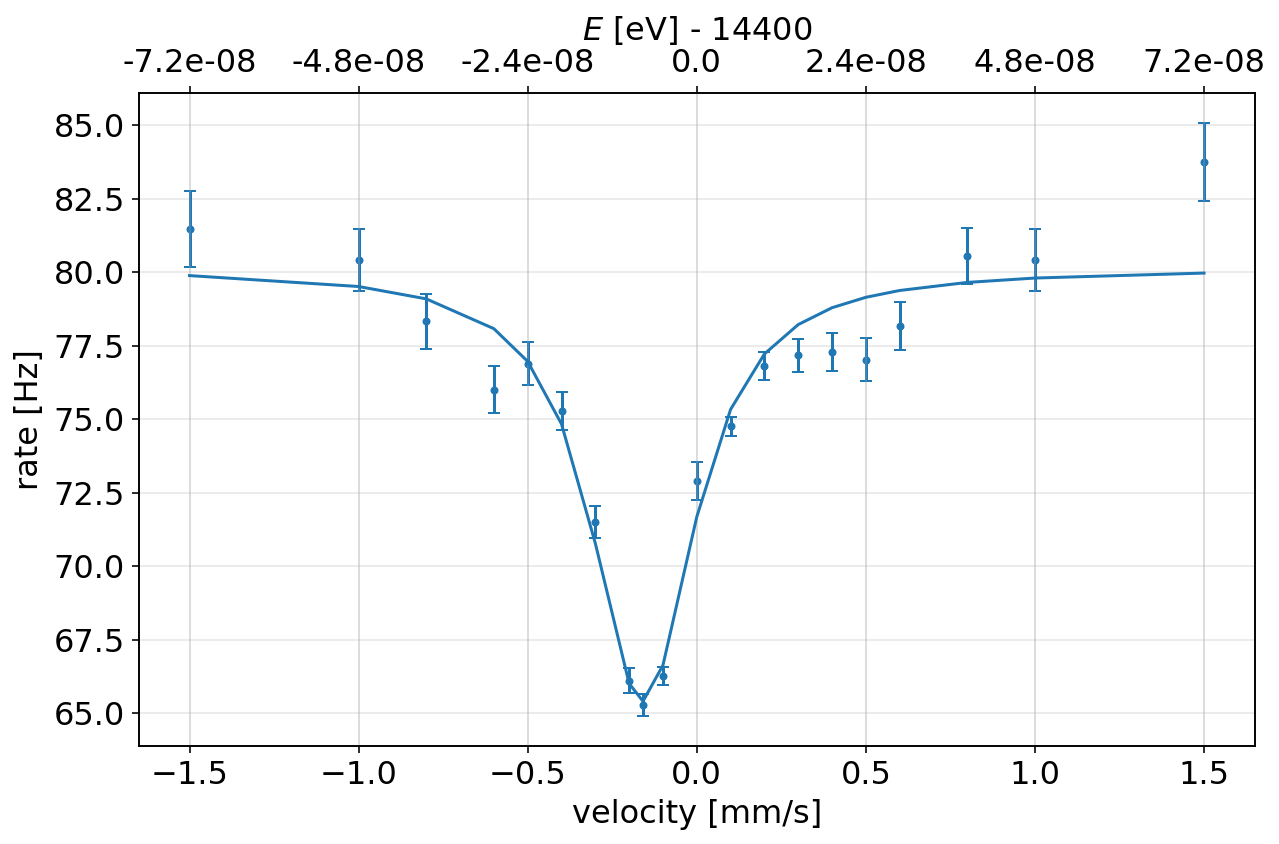

In [7]:
data_dir = '/Users/josephhowlett/research/mossbauer/analysis/gamma_spectroscopy/co57-mossbauer-spectra/'
filename = '20221026_1007.dat'
moss.load_from_file(join(data_dir, filename))
moss.plot()

vels = np.linspace(-1, 1, 100)
rates = moss.transmitted_spectrum(np.array(moss.measured_velocities))
from scipy.optimize import curve_fit
ffit = lambda x, a, b: (x/a) + b
popt, popcov = curve_fit(ffit, rates, moss.measured_rates, p0=[169.7, 60])
plt.plot(moss.measured_velocities, ffit(rates, *popt))
print(popt)
plt.ylabel('Hz')
plt.show()

### Check deltaEmin as a function of measurement velocity

In [8]:
mossbauer_relative_intensity = 0.0916
source_recoilless_fraction = 1.0
source_activity_Hz = 3.7e10 * 0.1  # 100 mCi

acquisition_time = 3600.0 * 24 * 31  # 1 month


### source parameters
source_parameters = dict(
    Eres=0.0,
    linewidth=E_to_vel(natural_linewidth),
    total_activity=source_activity_Hz * mossbauer_relative_intensity * source_recoilless_fraction
)

### absorber parameters
recoilless_fraction_A = 1.
t_mgcm2 = 0.13  # potassium ferrocyanide from ritverc
absorption_coefficient = 25.0  # cm^2 / mgFe57  (doublecheck)
absorber_parameters = dict(
    Eres=0.0,
    linewidth=E_to_vel(natural_linewidth),
    thickness_normalized=t_mgcm2 * absorption_coefficient * recoilless_fraction_A
)

### measurement parameters
PMT_OD = 2 * 2.54  # cm
PMT_distance = 10  # cm
solid_angle_fraction = (PMT_OD / PMT_distance)**2.0 / 16
measurement_parameters = dict(
    acquisition_time=acquisition_time,
    solid_angle_fraction=solid_angle_fraction,
    detection_efficiency=1.0
)

moss = mossbauer.MossbauerMeasurement(
    source_parameters,
    absorber_parameters,
    measurement_parameters
)

In [9]:
'%.2e' % (moss.source.total_activity * moss.solid_angle_fraction)

'5.47e+06'

In [10]:
'%.2e' % (moss.source.total_activity * moss.solid_angle_fraction * moss.acquisition_time)

'1.46e+13'

In [11]:
vels = np.logspace(-6, 0, 100000)
rates = moss.transmitted_spectrum(vels)
f = interp1d(rates, vels, fill_value='extrapolate')

#min_dE = rate_to_deltaEmin(acquisition_time, rates, ders)
nnew = (moss.acquisition_time*rates) + np.sqrt(moss.acquisition_time * rates)
vnew = f(nnew/moss.acquisition_time) - vels


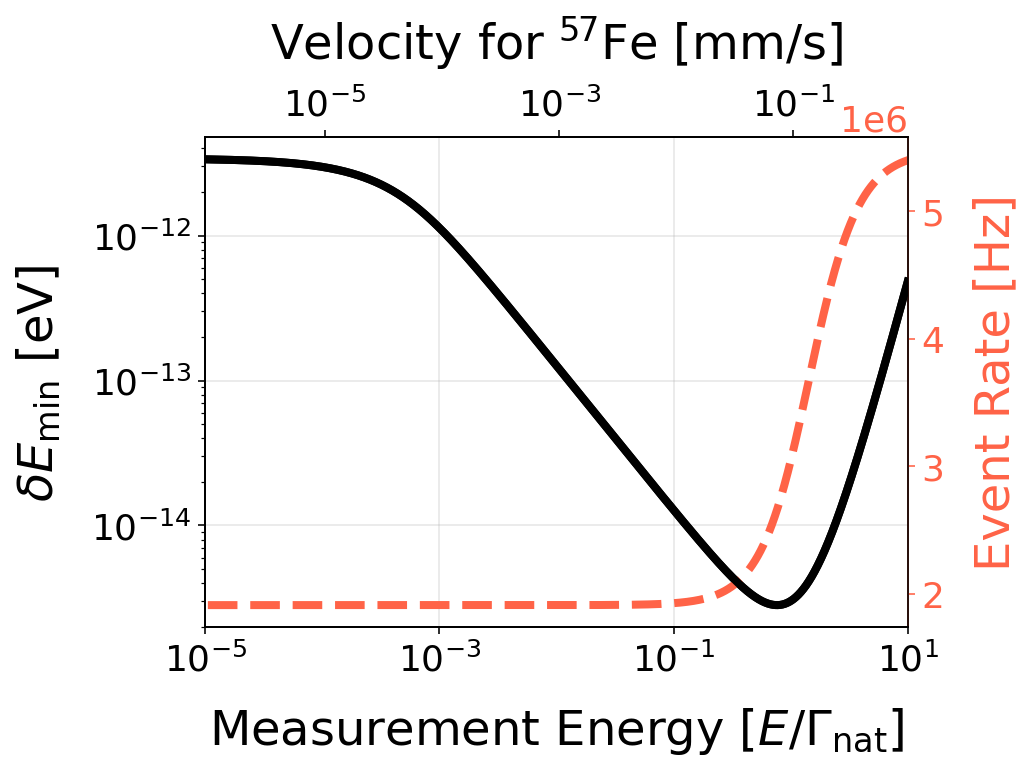

In [19]:
plt.style.use('bigsquare')
fig, ax = plt.subplots()
plt.plot(vels/E_to_vel(natural_linewidth), vel_to_E(vnew), color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Measurement Energy [$E/\Gamma_\mathrm{nat}$]')
plt.ylabel('$\delta E_\mathrm{min}$ [eV]')

ax2 = ax.twinx()
ax2.grid(False)
plt.plot(vels/E_to_vel(natural_linewidth), rates, linestyle='--', color='tomato')
plt.ylabel('Event Rate [Hz]')
change_axis_color(ax2, 'tomato')
ax2.spines['right'].set_color('tomato')
plt.xlim([1e-5, 1e1])


ax3 = ax.twiny()
plt.plot(vels, vel_to_E(vnew), color='k')
plt.xscale('log')
xrange = np.array(ax.get_xlim())
ax3.set_xlim(xrange*E_to_vel(natural_linewidth))
ax3.grid(False)
plt.xlabel('Velocity for $^{57}$Fe [mm/s]')
plt.tight_layout()
if True:
    plt.savefig('../plots/sensitivity_fvs_velocity_closed_form_only.png', dpi=200)
plt.show()

### Thickness broadening

In [13]:
ts = np.logspace(-2, 2, 100)
deltaE_opt = np.zeros_like(ts)

for i, t in enumerate(tqdm(ts)):
    moss.absorber.thickness_normalized = t
    ans = moss.get_deltaEmin_linear(vels=np.logspace(-4, 0, 1000), acquisition_time=acquisition_time)
    deltaE_opt[i] = vel_to_E(ans[2])

moss.absorber.thickness_normalized = t_mgcm2 * absorption_coefficient * recoilless_fraction_A

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.29it/s]


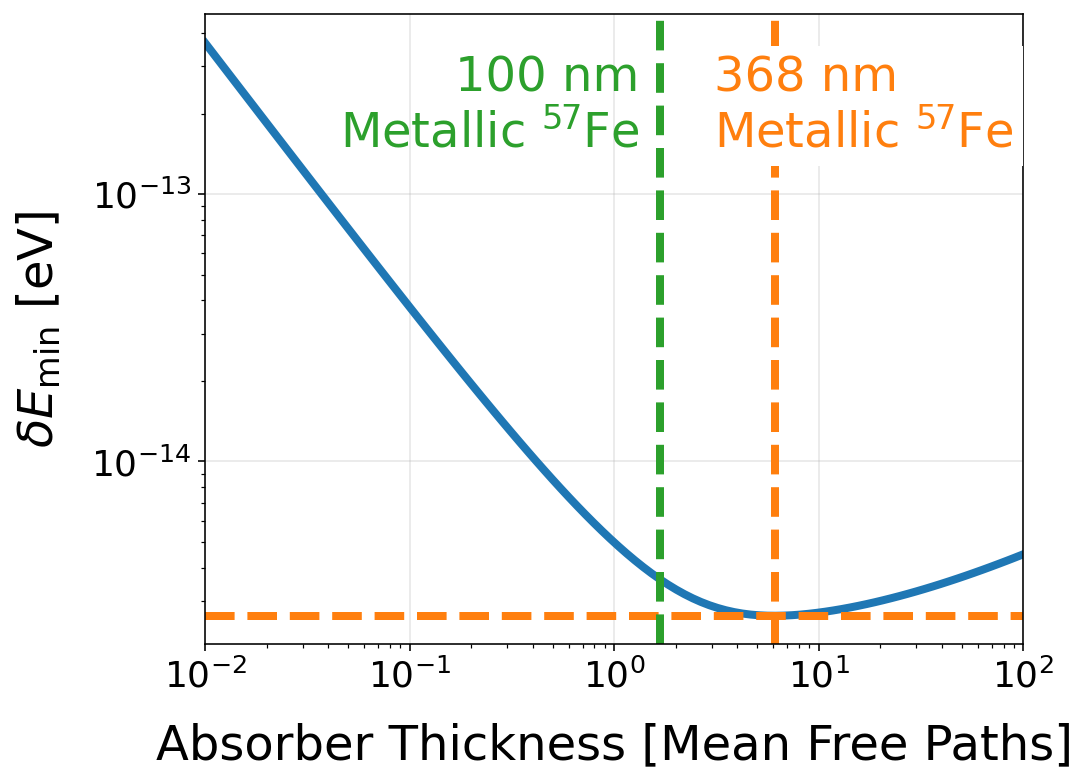

In [17]:
t_exp = (100./48)*0.8
#plt.plot(ts, deltaE, lw=3)
fig, ax = plt.subplots(figsize=(8, 6))
fsize = 24
plt.plot(ts, deltaE_opt, lw=4)
tmin = ts[np.argmin(deltaE_opt)]
plt.axvline(tmin, color='C1', linestyle='--', lw=4)
plt.axhline(deltaE_opt.min(), color='C1', linestyle='--', lw=4)
plt.annotate('%d nm\nMetallic $^{57}$Fe' % (tmin * 48/.8), (tmin*0.5, 1.5e-13), color='C1', fontsize=fsize, bbox=dict(color='w'))
plt.axvline(t_exp, color='C2', linestyle='--', lw=4)
plt.annotate('100 nm\nMetallic $^{57}$Fe' , (t_exp*0.8, 1.5e-13), color='C2', ha='right', fontsize=fsize)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'Absorber Thickness [Mean Free Paths]', fontsize=fsize)
plt.ylabel(r'$\delta E_\mathrm{min}$ [eV]', fontsize=fsize)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.xlim([0.01, 100])
plt.tight_layout()
if True:
    plt.savefig('../plots/effective_absorber_thickness_vs_sensitivity.png')
plt.show()

### Sensitivity

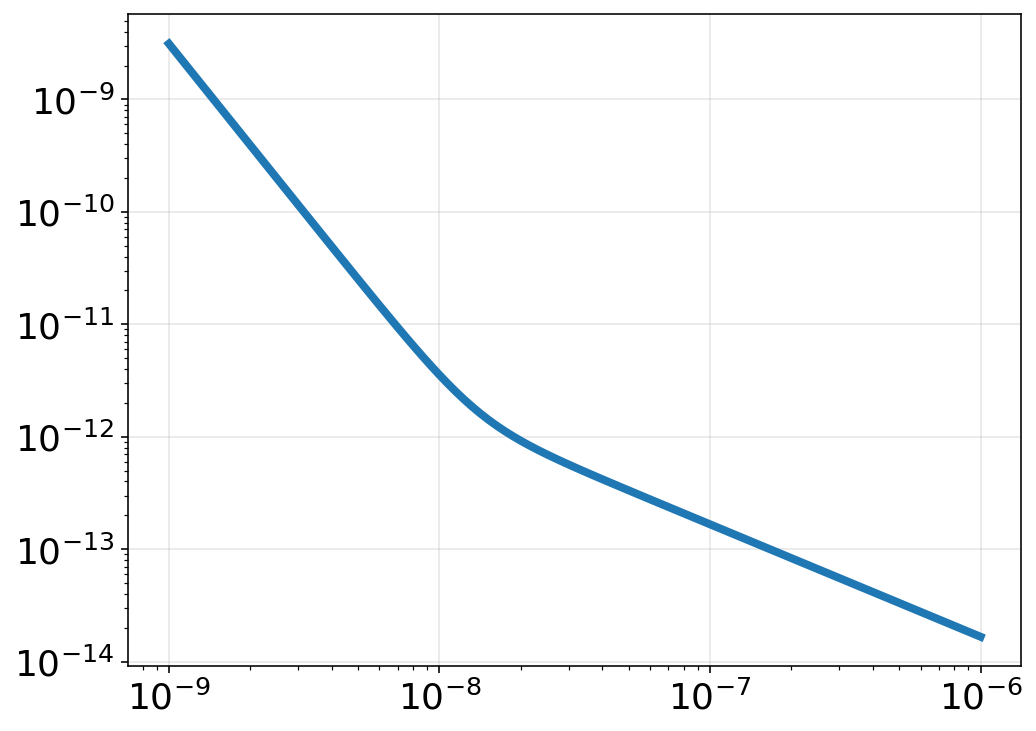

In [20]:
deltaEmin = vel_to_E(moss.get_deltaEmin_linear(vels=np.logspace(-4, 0, 1000))[2])
r, (yuk, alpha) = moss.get_sensitivity(deltaEmin, 'down_quark')
plt.plot(r, yuk)
plt.xscale('log')
plt.yscale('log')

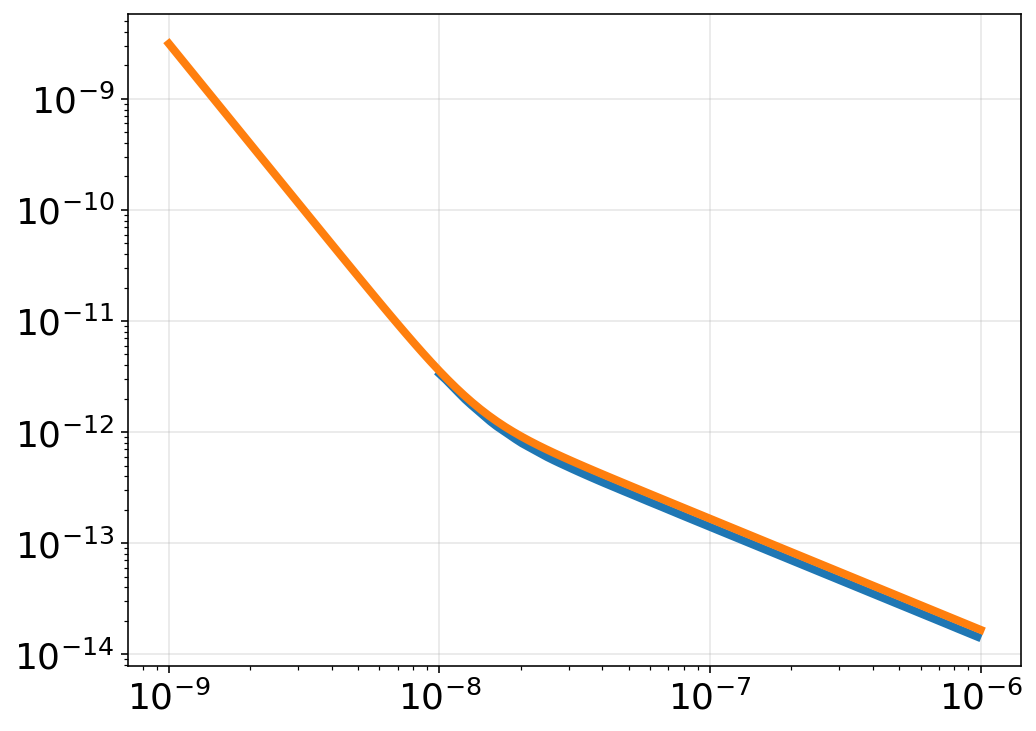

In [31]:
df = pd.read_csv('../../data/mossbauer_fe57_down_quark_modulus_sensitivity.txt', names=['a', 'b'])
plt.plot(df['a'], mossbauer.physics.alpha_to_yukawa(df['b']))
plt.plot(r, yuk)
plt.xscale('log')
plt.yscale('log')
plt.show()